In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from warnings import filterwarnings
filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10
)


In [8]:
crab_age_train = pd.read_csv('train.csv', verbose=True, index_col='id')

Tokenization took: 144.68 ms
Type conversion took: 84.50 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 10.97 ms
Type conversion took: 11.61 ms
Parser memory cleanup took: 0.01 ms


In [9]:
crab_age_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [10]:
crab_age_train.tail()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8
74050,I,0.9125,0.6750,0.2000,5.386405,2.055339,1.034757,1.700970,6


In [11]:
crab_age_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74051 entries, 0 to 74050
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             74051 non-null  object 
 1   Length          74051 non-null  float64
 2   Diameter        74051 non-null  float64
 3   Height          74051 non-null  float64
 4   Weight          74051 non-null  float64
 5   Shucked Weight  74051 non-null  float64
 6   Viscera Weight  74051 non-null  float64
 7   Shell Weight    74051 non-null  float64
 8   Age             74051 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 5.6+ MB


In [12]:
crab_age_train.shape

(74051, 9)

In [14]:
crab_age_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Sex,74051,3,M,27084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,74051.0,NaN,NaN,NaN,1.31746,0.287757,0.1875,1.15,1.375,1.5375,2.012815
Diameter,74051.0,NaN,NaN,NaN,1.024496,0.237396,0.1375,0.8875,1.075,1.2,1.6125
Height,74051.0,NaN,NaN,NaN,0.348089,0.092034,0.0,0.3,0.3625,0.4125,2.825
Weight,74051.0,NaN,NaN,NaN,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512
Shucked Weight,74051.0,NaN,NaN,NaN,10.10427,5.618025,0.028349,5.712424,9.90815,14.033003,42.184056
Viscera Weight,74051.0,NaN,NaN,NaN,5.058386,2.792729,0.042524,2.8633,4.989512,6.988152,21.54562
Shell Weight,74051.0,NaN,NaN,NaN,6.72387,3.584372,0.042524,3.96893,6.931453,9.07184,28.491248
Age,74051.0,NaN,NaN,NaN,9.967806,3.175189,1.0,8.0,10.0,11.0,29.0


<Axes: xlabel='Sex', ylabel='count'>

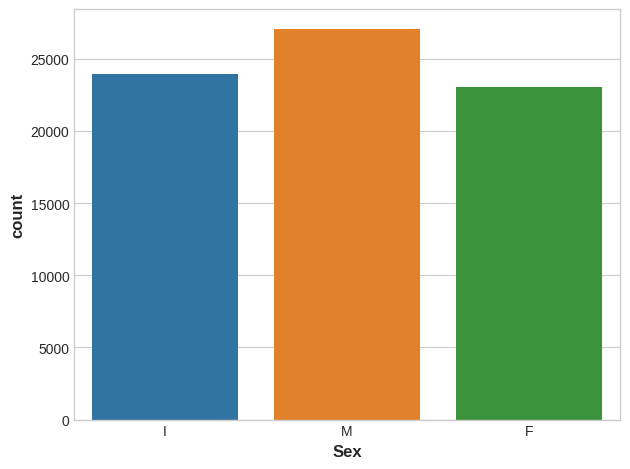

In [19]:
sns.countplot(x='Sex', data=crab_age_train)

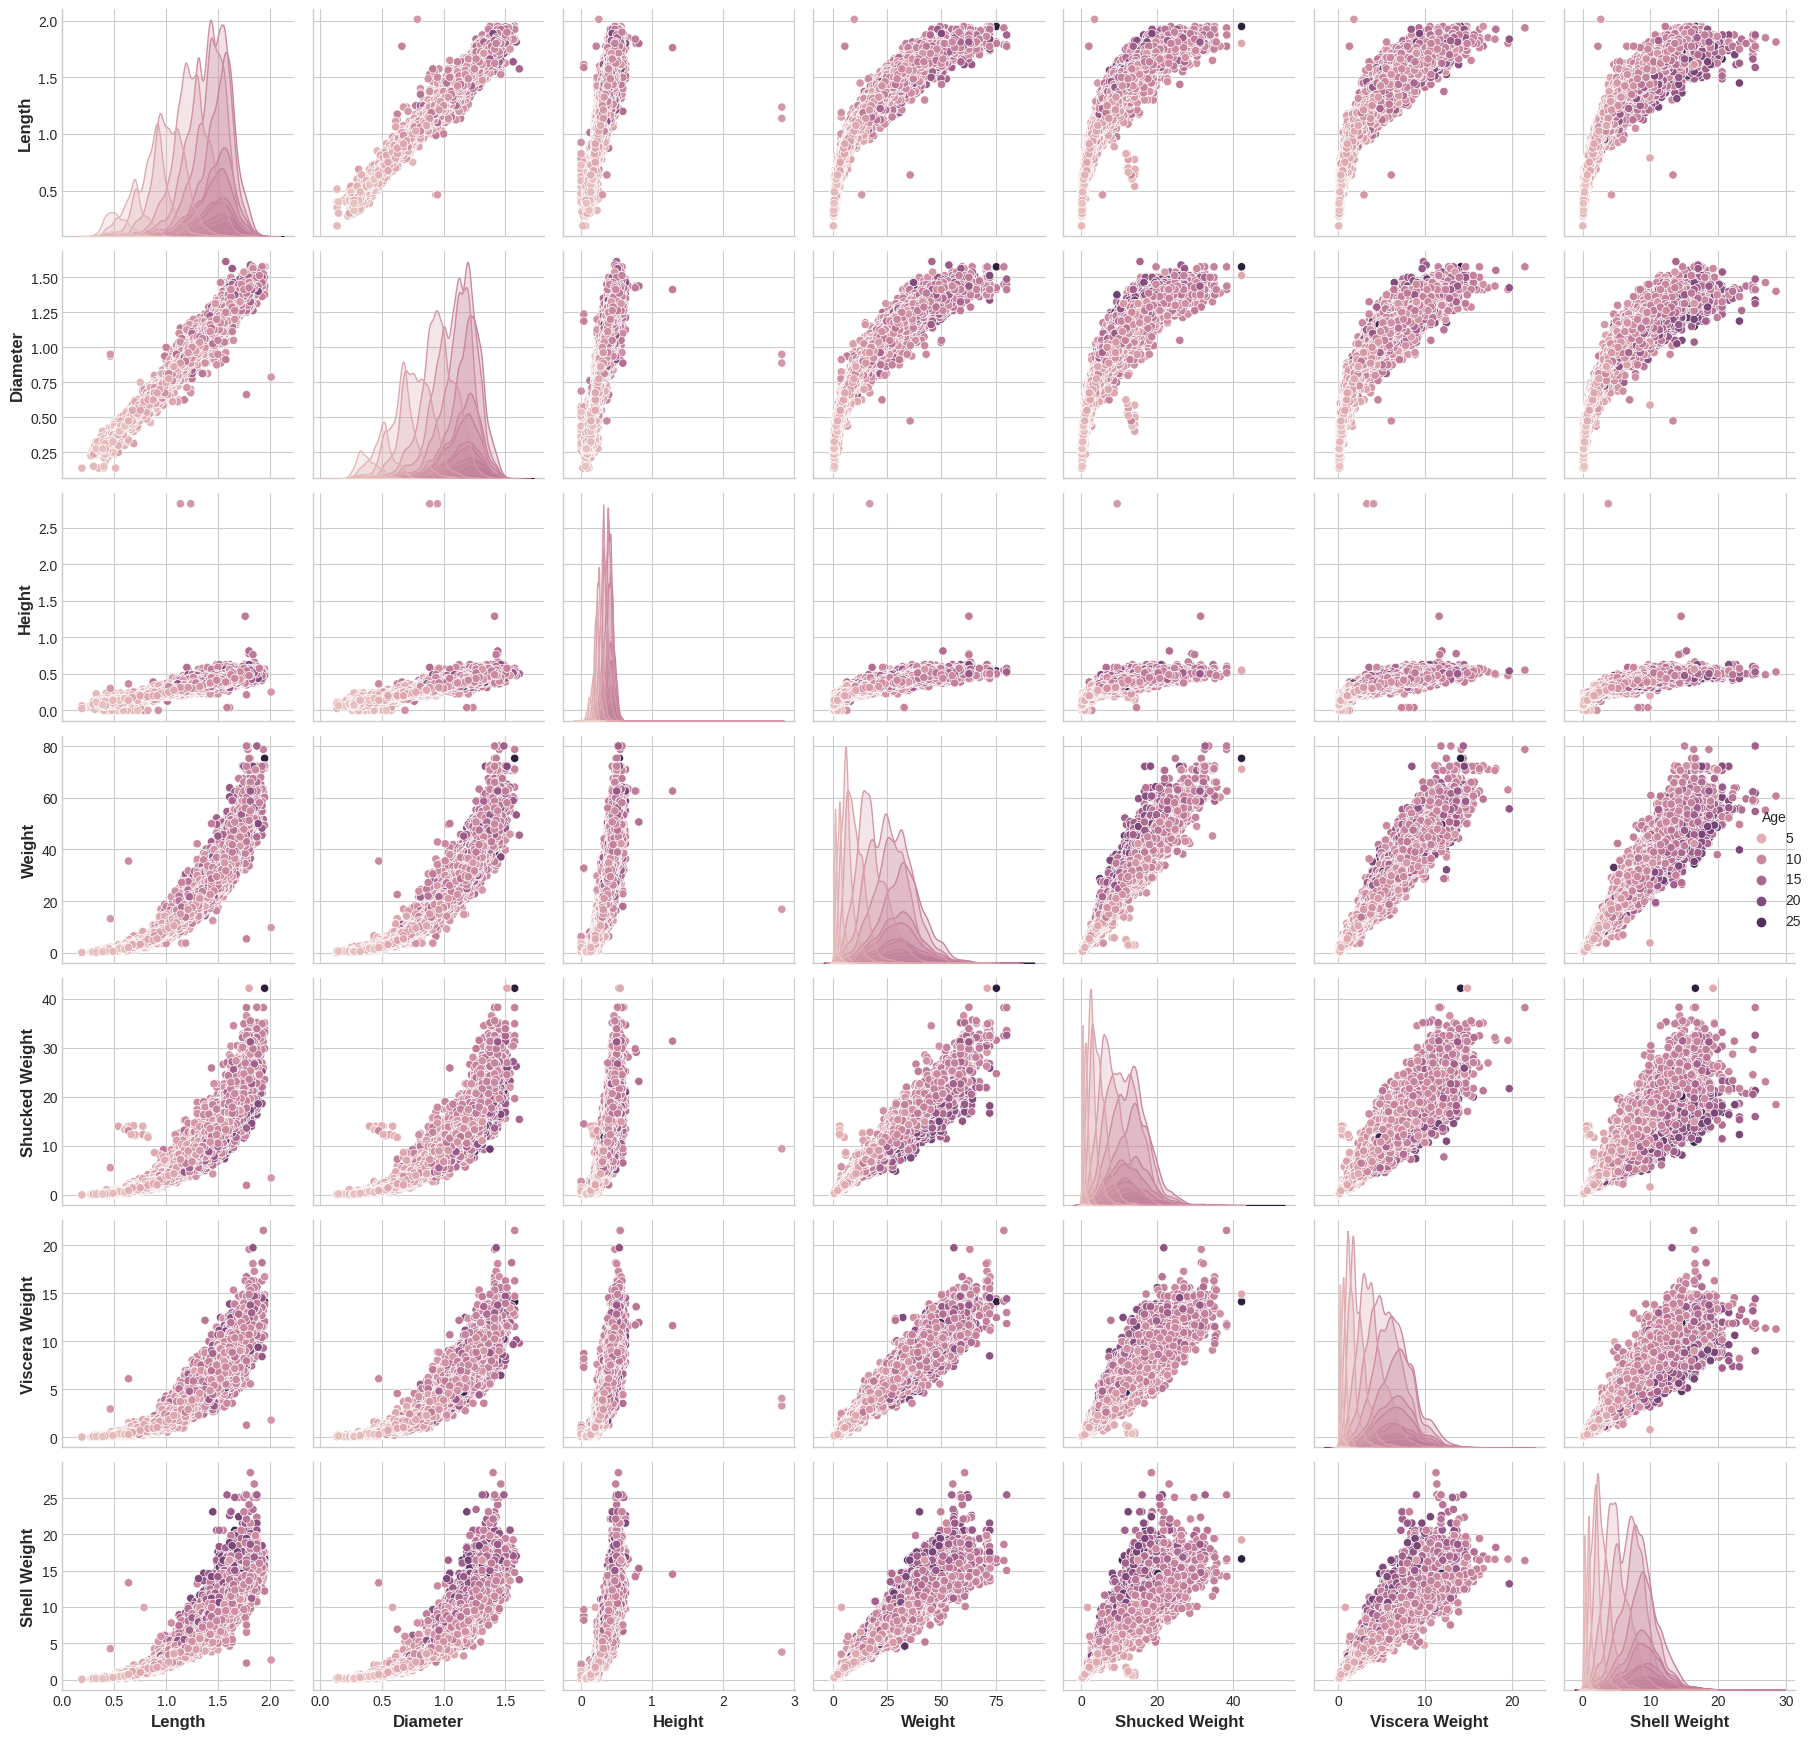

In [27]:
sns.pairplot(data=crab_age_train, hue='Age')
plt.show()

74051